<a href="https://colab.research.google.com/github/AnnaM-C/computational-intelligence/blob/main/Gradient_Descent_with_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
#ref:https://medium.com/@nagam808surya/cifar-10-image-classification-using-pytorch-90332041ba1f
#CIFAR-10 dataset from https://www.cs.toronto.edu/~kriz/cifar.html

In [98]:
#imports
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf


In [99]:
#check how many GPUs you have on the device
gpus = tf.config.list_physical_devices('GPU')
print("List of physical GPUs:", gpus)
print("Num GPUs Available: ", len(gpus))
if gpus:
# Use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

List of physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


In [100]:
#normalise pixel values (range:-1 to 1, mean:0.5, s.d:0.5)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size=4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [101]:
#index of trainset returns input, label
# print(trainset[0])
# input,label=trainset[0]
# print(label)

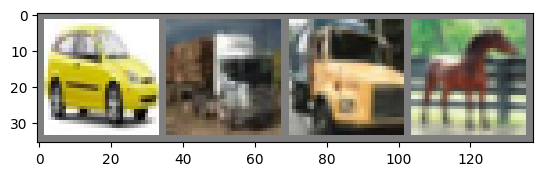

cartrucktruckhorse


In [102]:
#visualise images from the trainloader
def imshow(img):
    img=img/2+0.5 #unnormalise
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

#random image
dataiter=iter(trainloader)
images,labels=next(dataiter)

#show image
imshow(torchvision.utils.make_grid(images))

#print labels
print(''.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [103]:
#build the network (architecture)
#relu is used because it is fast

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net()


In [104]:
#choose an optimiser algorithm
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.95)
scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones=[30,80], gamma=0.1)


In [105]:
#epochs (entire run of dataset multiple forward and backward propogations to update weights = 1 epoch)
lossTracker=[]

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    running_loss_track=0.0
    #in each epoch this is the forward and backward propogation loop to optimise the loss.
    #restarts the loop without losses from the last step meaning it starts updating the weights without considering losses from last step, focuses on the current loss
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        #zero the parameter gradients
        optimiser.zero_grad()

        #forward + backward + optimise
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss_track+=running_loss/2000
            running_loss = 0.0
    scheduler1.step()
    scheduler2.step()

    #calculate average losses
    running_loss_track=running_loss_track/5
    print("Average loss->",running_loss_track)
    lossTracker.append(running_loss_track)

print('Finished Training')

[1,  2000] loss: 2.187
[1,  4000] loss: 1.817
[1,  6000] loss: 1.665
[1,  8000] loss: 1.584
[1, 10000] loss: 1.524
[1, 12000] loss: 1.489
Average loss-> 2.053121436959505
[2,  2000] loss: 1.408
[2,  4000] loss: 1.387
[2,  6000] loss: 1.372
[2,  8000] loss: 1.345
[2, 10000] loss: 1.312
[2, 12000] loss: 1.306
Average loss-> 1.6260832945108414
[3,  2000] loss: 1.242
[3,  4000] loss: 1.265
[3,  6000] loss: 1.228
[3,  8000] loss: 1.212
[3, 10000] loss: 1.202
[3, 12000] loss: 1.212
Average loss-> 1.4722633856285363
[4,  2000] loss: 1.107
[4,  4000] loss: 1.163
[4,  6000] loss: 1.145
[4,  8000] loss: 1.135
[4, 10000] loss: 1.122
[4, 12000] loss: 1.126
Average loss-> 1.359476475790143
[5,  2000] loss: 1.048
[5,  4000] loss: 1.053
[5,  6000] loss: 1.060
[5,  8000] loss: 1.051
[5, 10000] loss: 1.076
[5, 12000] loss: 1.072
Average loss-> 1.2721220378530211
[6,  2000] loss: 0.943
[6,  4000] loss: 0.985
[6,  6000] loss: 1.003
[6,  8000] loss: 1.000
[6, 10000] loss: 0.988
[6, 12000] loss: 1.016
Aver

In [106]:
PATH='./cifar_net.pth'
torch.save(model.state_dict(),PATH)

In [107]:
model=Net()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

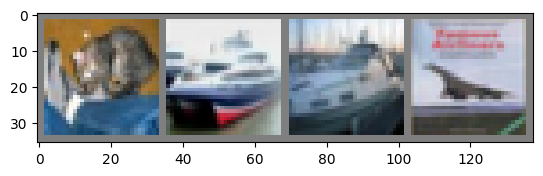

GroundTruth:    cat  ship  ship plane


In [108]:
#random image
dataiter=iter(testloader)
images,labels=next(dataiter)

#show image
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [109]:
outputs=model(images)

In [110]:
_,predicted=torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s'%classes[predicted[j]]
                             for j in range(4)))

Predicted:    cat  ship  ship  ship


In [111]:
#overall accuracy
correct=0
total=0
#since we're not training, we dont need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images,labels=data
        #calculate outputs by running images through the network
        outputs=model(images)
        #the class with the highest energy is what we choose as prediction
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct/total))

Accuracy of the network on the 10000 test images: 63 %


In [112]:
#accuracy for each class
#prepare to count predictions for each class
correct_pred={classname: 0 for classname in classes}
total_pred={classname: 0 for classname in classes}

#no gradients needed
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=model(images)
        _,predictions=torch.max(outputs,1)
        #collect the correct predictions for each class
        for label,prediction in zip(labels,predictions):
            if label==prediction:
                correct_pred[classes[label]]+=1
            total_pred[classes[label]]+=1

#print accuracy for each class
for classname,correct_count in correct_pred.items():
    accuracy=100*float(correct_count)/total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,accuracy))


Accuracy for class plane is: 75.4 %
Accuracy for class car   is: 63.1 %
Accuracy for class bird  is: 45.7 %
Accuracy for class cat   is: 42.0 %
Accuracy for class deer  is: 59.9 %
Accuracy for class dog   is: 53.7 %
Accuracy for class frog  is: 74.4 %
Accuracy for class horse is: 69.2 %
Accuracy for class ship  is: 77.4 %
Accuracy for class truck is: 76.6 %


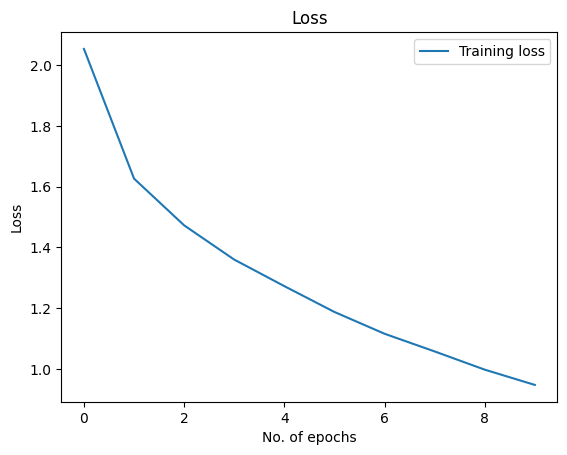

In [114]:
plt.plot(np.arange(0,10), lossTracker, label='Training loss')
plt.title('Loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()